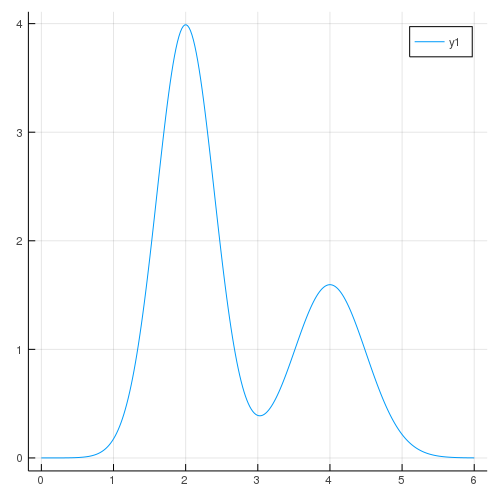

In [1]:
include("../src/StatReg.jl")
using .StatReg
using Plots
plotly()
gr(size=(500,500), html_output_format=:png)
using QuadGK

a = 0
b = 6.

function phi(x::Real)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5
    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))

myplot = plot(x, phi.(x))

In [7]:
using QuadGK

kernel(x::Real, y::Real) = getOpticsKernels("gaussian")(x, y)

convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=30))
ftrue = convolution.(y)

sig = 0.1*ftrue + [0.01 for i = 1:Base.length(ftrue)]

using Compat, Random, Distributions
noise = []
Random.seed!(1234)
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end

f = ftrue + noise

# plot(y, f, title="Integrated function",label=["f(y)"],seriestype=:scatter, yerr=sig)
# savefig("integrated.png")

30-element Array{Float64,1}:
 0.01700904938267963 
 0.013089718360211576
 0.059569815776921664
 0.14304683679959884 
 0.4031177679658159  
 0.8713644732545356  
 1.2425047687097943  
 1.6993998427880443  
 2.4194914403770187  
 2.5229814564173854  
 2.5735443244870426  
 2.479502890275351   
 2.0533712753740447  
 ⋮                   
 1.1570634766038586  
 1.022403806248473   
 1.3952610882384748  
 0.8981426534486471  
 0.9596301737802788  
 0.5432067359323931  
 0.24741443556917614 
 0.24371750349313984 
 0.1368731213211527  
 0.07807122460668757 
 0.024971640267777623
 0.004876099364484613

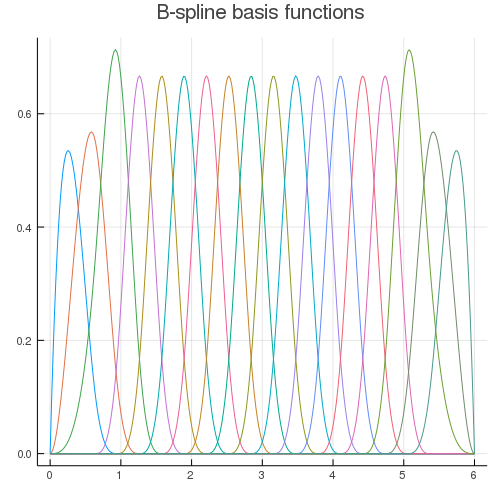

┌ Info: Cubic spline basis is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:101


In [3]:
basis = CubicSplineBasis(a, b, 20, "dirichlet")
p = plot()
for func in basis.basis_functions
    p = plot!(x, func.f.(x), title="B-spline basis functions", legend=false, show = true)
end
display(p)
# savefig("basis.png")

In [4]:
Omega = omega(basis, 2)
model = MCMCUnfolder(basis, [Omega], "EmpiricalBayes"; alphas=nothing, lower=[1e-8], higher=[10.], initial=[0.3])
println()

┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:122
┌ Info: Omega caclulated successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:140


┌ Info: MCMCMatrixUnfolder is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/mcmc.jl:56
┌ Info: MCMCUnfolder is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/mcmc.jl:213


In [11]:
result = solve(model, kernel, f, sig, y, chains=3);

┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/mcmc.jl:258
┌ Info: Starting discretize kernel...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:44
┌ Info: Kernel was discretized successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:55
┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/mcmc.jl:101
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/ta_nyan/.julia/packages/BAT/YpnQS/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/ta_nyan/.julia/packages/BAT/YpnQS/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/ta_nyan/.julia/packages/BAT/YpnQS/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT

┌ Info: PhiVec is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solution_utils/vector.jl:64


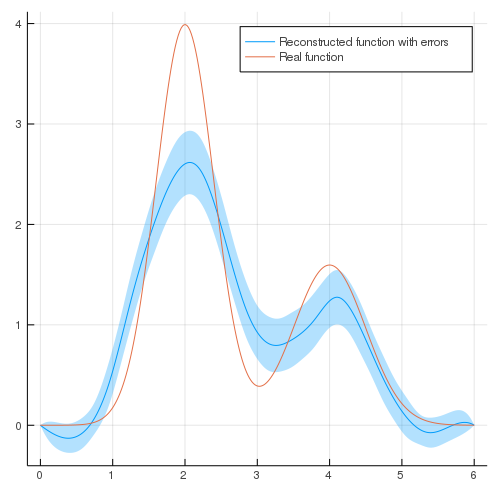

In [10]:
phivec = PhiVec(result, basis)

phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)

plot(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3, label="Reconstructed function with errors")
plot!(x, phi.(x), label="Real function")
# savefig("reconstructed.png")